## Load data

In [ ]:
import pandas as pd
from utils import (
    sig,
    TwoFlashesProcessingStrategy_Explore,
)

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


In [3]:
lspq_data = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Fit"].values
soas = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Delay"].values

In [4]:
from skneuromsi.neural import Paredes2025
from skneuromsi.sweep import ParameterSweep
from utils import TwoFlashesProcessingStrategy_Explore


def two_flashes_job(a_tau, v_tau, m_tau, cm_weight, fb_weight, ff_weight):

    model = Paredes2025(
        time_range=(0, 600),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=10,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy_Explore(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=0.5,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
    )

    return res


results_list, two_flashes_res, _ = two_flashes_job(
    a_tau=6.560e00,
    v_tau=9.191e00,
    m_tau=1.200e02,
    cm_weight=1.036e-03,
    fb_weight=6.231e-01,
    ff_weight=3.892e00,
)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt


def plot_res_per_soa_small(result_list, position=15):
    fig, axs = plt.subplots(1, 3, figsize=(14, 3), sharex=True, sharey=True, dpi=300)
    dashes_dict = {"auditory": "", "visual": "", "multi": (2, 2)}
    idx = -1
    for res in result_list[0::7]:
        idx += 1
        col = idx
        sub_plot = res.plot.linet(
            position=position,
            ax=axs[col],
            style="modes",
            dashes=dashes_dict,
        )[0]
        sub_plot.get_legend().remove()
        sub_plot.set_title(
            "SOA " + str(int(res.run_parameters.auditory_soa)) + " ms",
            size=12,
            weight="bold",
        )
        sub_plot.set_ylabel("Neural activation", size=11, weight="bold")
        sub_plot.set_xlabel("Time (ms)", size=11, weight="bold")
        sub_plot.set_xlim(0, 50000)
        sub_plot.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
        new_labels = [label.get_text()[:-2] for label in sub_plot.get_xticklabels()]
        if new_labels:
            new_labels[1] = "0"
        sub_plot.set_xticklabels(new_labels)
    handles, legend_labels = sub_plot.get_legend_handles_labels()
    new_legend_labels = ["Auditory", "Visual", "Multisensory"]
    fig.legend(handles, new_legend_labels, loc="center right", borderaxespad=0.2)
    fig.suptitle(None)
    fig.savefig("drafts/FIG2.eps", bbox_inches="tight", format="eps")
    plt.subplots_adjust(wspace=0.1)
    plt.show()

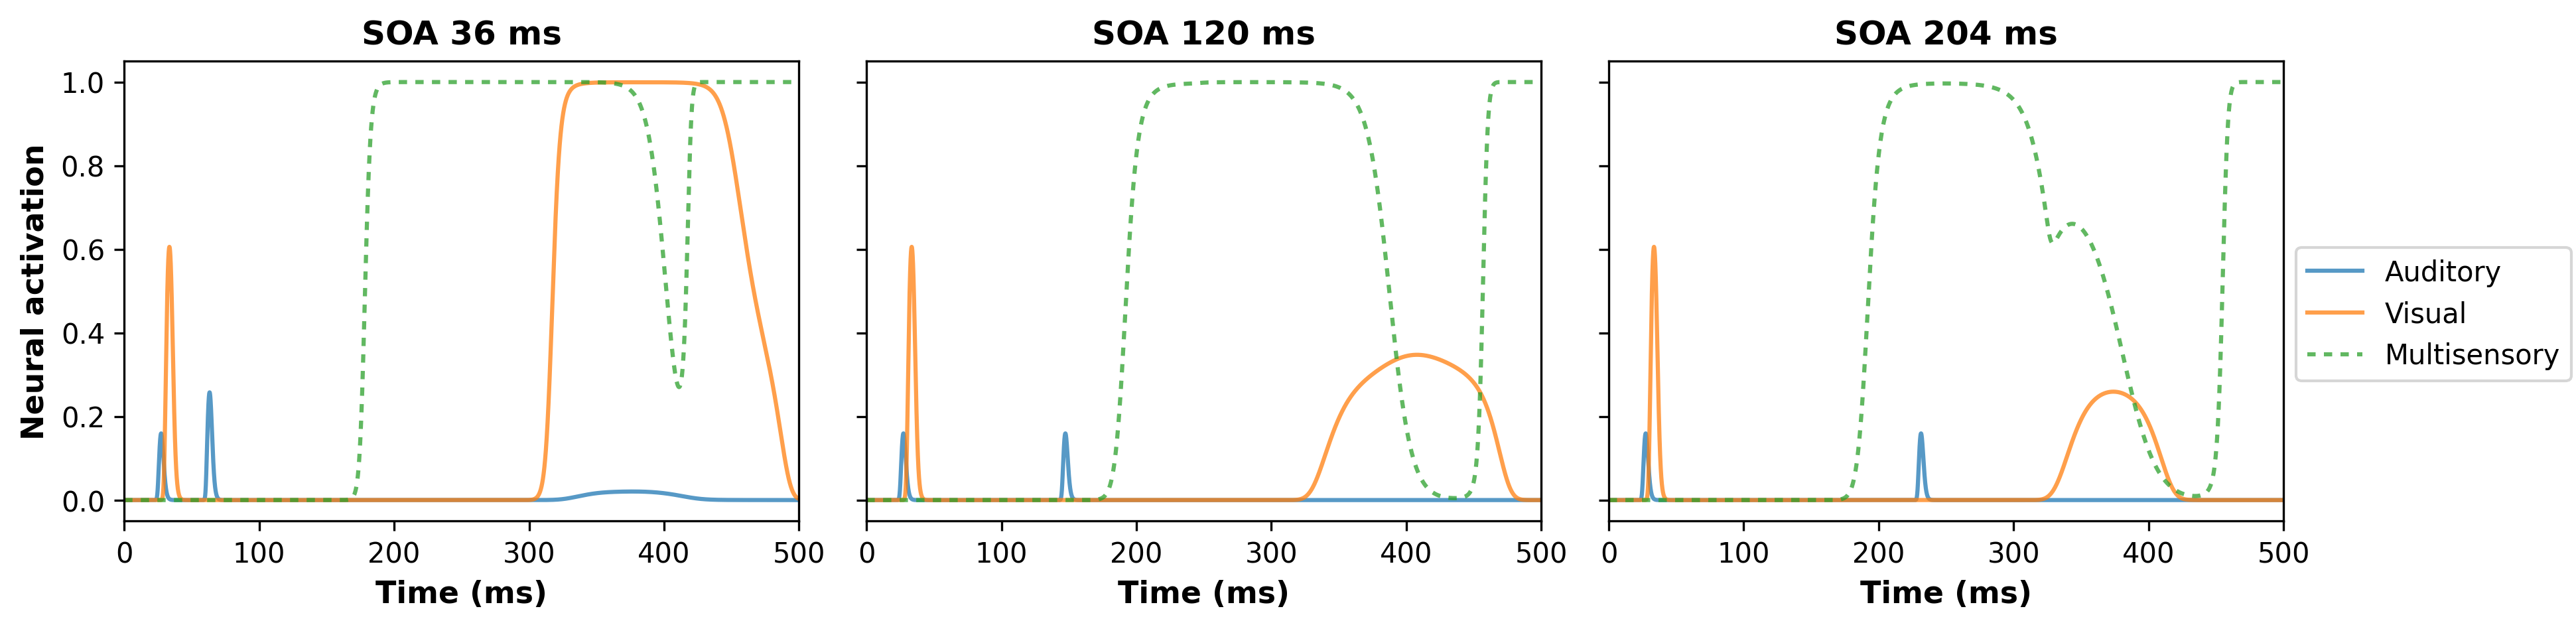

In [8]:
plot_res_per_soa_small(results_list)